In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import math
from multiprocessing import Pool
from tqdm import tqdm
from scipy import stats
## init
mySpecie='Homo_sapiens'
#prealigned_dir='/cellar/users/btsui/all_seq_snp/Homo_sapiens_all_merged_snp.TCGA.prealigned.pickle'
targetted_align_dir='/cellar/users/btsui/all_seq_snp/Homo_sapiens_all_merged_snp.TCGA.pickle'
manifest_dir='/cellar/users/btsui/Project/METAMAP/notebook/RapMapTest/XGS_WGS/./tcga_lgg_wgs_bams.df.wxs_rnaseq.pickle'

In [4]:
targetted_df=pd.read_pickle(targetted_align_dir).loc["TCGA"]

In [5]:
all_UUIDs=targetted_df.index.get_level_values('Run_digits').unique()

In [6]:
#883, 1427
print ('n UUID:',len(all_UUIDs))

n UUID: 1570


In [7]:
#targetted_df.head()

In [8]:
### use andrea mapping to map from TCGA barcode to UUID. 

### annotate metadata

In [9]:
manifest_df=pd.read_pickle(manifest_dir)

In [10]:
manifest_df['processed']=manifest_df.file_id.isin(all_UUIDs)

In [11]:
uuid_barcode_mapDf=pd.read_csv('/cellar/users/andreabc/GDC_barcodes/uuid_barcode_map.txt',sep='\t').set_index('file_id')

In [12]:
manifest_df['sample_barcode']=uuid_barcode_mapDf.loc[manifest_df.file_id]['sample_barcode'].values

In [13]:
m_data_category=manifest_df.data_category=='Raw Sequencing Data'
m_experimental_strategy=manifest_df['experimental_strategy'].isin(['RNA-Seq','WXS'])

In [14]:
manifest_df_sub=manifest_df[manifest_df['processed']&m_data_category&m_experimental_strategy]

In [15]:
tmpVC=manifest_df_sub['sample_barcode'].value_counts()
with_both=tmpVC.index[tmpVC==2]


In [16]:
len(with_both)

524

In [17]:
manifest_df_w_RNA_WXS=manifest_df_sub[manifest_df_sub.sample_barcode.isin(with_both)]


In [18]:
#g=manifest_df_w_RNA_WXS.groupby(['sample_barcode','experimental_strategy'])
#[manifest_df_sub['sample_barcode']=='TCGA-HT-A4DV-01A']

In [19]:
#manifest_df_sub

In [20]:
#queryBarcode='TCGA-HT-A4DV-01A'
#rnaseq_uuid=g.get_group((queryBarcode,'RNA-Seq'))['file_id'].iloc[0]
#wxs_uuid=g.get_group((queryBarcode,'WXS'))['file_id'].iloc[0]

In [21]:
rnaseq_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='WXS']['file_id'].unique()


In [22]:
targetted_df.head()

features                                              ReadDepth  \
Run_digits                           Chr Pos    base              
08ce1dd9-3167-4fe4-8619-724727a32a36 1   14727  A            18   
                                                G           280   
                                         630825 T            11   
                                         630833 C             9   
                                         833068 G             2   

features                                              AverageBaseQuality  
Run_digits                           Chr Pos    base                      
08ce1dd9-3167-4fe4-8619-724727a32a36 1   14727  A                     28  
                                                G                     32  
                                         630825 T                     32  
                                         630833 C                     34  
                                         833068 G                     34

In [23]:
inVcfDir='/data/cellardata/users/btsui/dbsnp/Homo_sapiens/All_20170710.f1_byte2_not_00.vcf.gz' 
vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(np.str)


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
"""for _,vcfDfRowS in vcfDf.iterrows():
    query_chromosome,qeury_corrdinate=vcfDfRowS['Chr'],vcfDfRowS['Pos']
    selectedBase=vcfDfRowS['AltBase']
    break"""

varscanVcfMerged=pd.read_pickle('/cellar/users/btsui/Project/METAMAP/notebook/RapMapTest/XGS_WGS/Data/TCGA_VCF.varscan_dr.pickle')

In [25]:
varscanVcfMerged.head()

Group                                                       one_vcf_df        \
VCF_columns                                                      index CHROM   
TUMOR                        NORMAL                                            
TCGA-DU-5870-01A-11D-1705-08 TCGA-DU-5870-10A-01D-1705-08 0          0  chr1   
                                                          1          1  chr1   
                                                          2          2  chr1   
                                                          3          3  chr1   
                                                          4          4  chr1   

Group                                                                        \
VCF_columns                                                      POS ID REF   
TUMOR                        NORMAL                                           
TCGA-DU-5870-01A-11D-1705-08 TCGA-DU-5870-10A-01D-1705-08 0   944131  .   A   
                                                          1   944136  .   T   
                                                          2  1300684  .   C   
                                                          3  1713611  .   C   
                                                          4  1713674  .   T   

Group                                                                        \
VCF_columns                                                 ALT QUAL FILTER   
TUMOR                        NORMAL                                           
TCGA-DU-5870-01A-11D-1705-08 TCGA-DU-5870-10A-01D-1705-08 0   C    .   PASS   
                                                          1   C    .   PASS   
                                                          2   A    .   PASS   
                                                          3   T    .   PASS   
                                                          4   C    .   PASS   

Group                                                                                                         \
VCF_columns                                                                                             INFO   
TUMOR                        NORMAL                                                                            
TCGA-DU-5870-01A-11D-1705-08 TCGA-DU-5870-10A-01D-1705-08 0  DP=89;GPV=1E0;SOMATIC;SPV=5.0789E-2;SS=2;SSC=12   
                                                          1  DP=92;GPV=1E0;SOMATIC;SPV=1.8932E-2;SS=2;SSC=17   
                                                          2  DP=71;GPV=1E0;SOMATIC;SPV=6.3354E-2;SS=2;SSC=11   
                                                          3  DP=59;GPV=1E0;SOMATIC;SPV=4.5001E-3;SS=2;SSC=23   
                                                          4   DP=42;GPV=1E0;SOMATIC;SPV=3.252E-2;SS=2;SSC=14   

Group                                                                                 \
VCF_columns                                                                   FORMAT   
TUMOR                        NORMAL                                                    
TCGA-DU-5870-01A-11D-1705-08 TCGA-DU-5870-10A-01D-1705-08 0  GT:GQ:DP:RD:AD:FREQ:DP4   
                                                          1  GT:GQ:DP:RD:AD:FREQ:DP4   
                                                          2  GT:GQ:DP:RD:AD:FREQ:DP4   
                                                          3  GT:GQ:DP:RD:AD:FREQ:DP4   
                                                          4  GT:GQ:DP:RD:AD:FREQ:DP4   

Group                                                       ... normal_df      \
VCF_columns                                                 ...        DP  RD   
TUMOR                        NORMAL                         ...                 
TCGA-DU-5870-01A-11D-1705-08 TCGA-DU-5870-10A-01D-1705-08 0 ...        20  18   
                                                          1 ...        25  22   
                                                          2 ...        18  16   
     

In [26]:
topTcgaVcfDf=varscanVcfMerged['one_vcf_df'].groupby(
    ['CHROM','POS','ALT']).size().sort_values(ascending=False).reset_index(name='Count')#.iloc[:100]

In [27]:
#topTcgaVcfDf.iloc[:100]

In [28]:
#371/524.0

In [29]:
#topTcgaVcfDf['Count']

In [30]:
topTcgaVcfDf['CHROM']=topTcgaVcfDf['CHROM'].str.replace('chr','')

In [31]:
tmpDf=topTcgaVcfDf.set_index(['CHROM','POS'],drop=False)

In [32]:
targetted_multI=vcfDf.set_index(['Chr','Pos']).index

In [84]:
#altBaseS=vcfDf.set_index(['Chr','Pos'])['AltBase'].str.split(',',expand=True).stack()

#chrPosAltI=altBaseS.reset_index(name='AltBase').set_index(['Chr','Pos','AltBase']).index

In [114]:
tmpDf.head()

CHROM        POS ALT  Count  in_targeted_ref
CHROM POS                                                   
2     208248388     2  208248388   T    371             True
17    7673803      17    7673803   A     59             True
11    78226616     11   78226616   G     31            False
16    15763747     16   15763747   C     30            False
3     186079938     3  186079938   G     29            False

In [107]:
tmpDf['in_targeted_ref']=tmpDf.index.isin(targetted_multI)

In [113]:
#tmpDf['in_targeted_ref']
tmpDf[tmpDf['Count']>20]['in_targeted_ref'].sum()
len(tmpDf[tmpDf['Count']>20]['in_targeted_ref'])

77

In [118]:
tmpDf['in_targeted_ref'].mean()

0.014626543579906486

In [34]:
topTcgaVcfDf_inTargeted=tmpDf[tmpDf['in_targeted_ref']]

In [92]:
topTcgaVcfDf_inTargeted

CHROM        POS ALT  Count
CHROM POS                                  
2     208248388     2  208248388   T    371
17    7673803      17    7673803   A     59
11    46778229     11   46778229   C     20
      61955099     11   61955099   C     19
2     208248389     2  208248389   A     17
14    32092134     14   32092134   A     14
20    10645368     20   10645368   G     13
2     208248389     2  208248389   C     12
15    90088606     15   90088606   T     12
17    7673802      17    7673802   T     11
8     142877758     8  142877758   C     11
X     24789042      X   24789042   T     11
2     178554496     2  178554496   C     10
1     109690516     1  109690516   C     10
17    7674872      17    7674872   C     10
13    95062893     13   95062893   A      9
6     29944050      6   29944050   A      9
2     208248389     2  208248389   T      9
10    38641086     10   38641086   A      9
3     10063977      3   10063977   C      9
X     24788994      X   24788994   T      9
12    6018369      12    6018369   G      9
      49951033     12   49951033   C      8
6     80127535      6   80127535   T      8
17    7674220      17    7674220   T      8
      7675076      17    7675076   C      8
      7675088      17    7675088   T      8
1     215786811     1  215786811   C      8
7     140734786     7  140734786   A      8
19    41009358     19   41009358   G      8
...               ...        ...  ..    ...
4     6302187       4    6302187   A      1
      8005201       4    8005201   T      1
      7654128       4    7654128   T      1
3     195699434     3  195699434   C      1
      193645626     3  193645626   A      1
4     947730        4     947730   T      1
3     196230099     3  196230099   T      1
      100728780     3  100728780   T      1
      113401767     3  113401767   G      1
      114339010     3  114339010   T      1
      114339384     3  114339384   G      1
      97993153      3   97993153   A      1
      73062217      3   73062217   C      1
      97768199      3   97768199   T      1
      78688812      3   78688812   A      1
      78614806      3   78614806   A      1
      78627272      3   78627272   A      1
      87259754      3   87259754   A      1
      132243465     3  132243465   G      1
      142547597     3  142547597   T      1
      138946428     3  138946428   T      1
      139495061     3  139495061   G      1
      122261395     3  122261395   C      1
      122283764     3  122283764   A      1
      123614028     3  123614028   G      1
      119876393     3  119876393  TA      1
      120638490     3  120638490   A      1
      129528683     3  129528683   A      1
      129528708     3  129528708   G      1
      126131662     3  126131662   A      1

[2196 rows x 4 columns]

In [36]:
threshold=2

In [45]:
#threshold=2

#selectedBase='T'
#query_chromosome, qeury_corrdinate='2',208248388
failedS_L=[]
roc_auc_l=[]
#m_chr=targetted_df.index.get_level_values('Chr')==query_chromosome
Pos_array=targetted_df.index.get_level_values('Pos')
successCount=0
for vcfIndex,vcfDfRowS in topTcgaVcfDf_inTargeted.iterrows():
    try:
        query_chromosome,qeury_corrdinate=vcfDfRowS['CHROM'].replace('chr',''),vcfDfRowS['POS']
        selectedBases=vcfDfRowS['ALT']

        window_size=0
        
        m_pos=(Pos_array>=(qeury_corrdinate-window_size))&(Pos_array<=(qeury_corrdinate+window_size))
        if m_pos.sum()<10:
            print ('failed')
            continue
        m_qual=targetted_df['AverageBaseQuality']>=30
        #if m_pos.sum()>=0:
        targetted_df_sub=targetted_df[m_pos&m_qual]

        index_metaDf=targetted_df_sub.index.to_frame()

        index_metaDf['sample_barcode']=manifest_df_w_RNA_WXS.set_index('file_id').loc[index_metaDf['Run_digits']]['sample_barcode'].values

        multI=index_metaDf.set_index(['sample_barcode','Run_digits','Chr','Pos','base']).index
        targetted_df_sub.index=multI


        rnaseq_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='RNA-Seq']['file_id'].unique()
        m_uuid=targetted_df_sub.index.get_level_values('Run_digits').isin(rnaseq_uuids)
        rnaseq_df=targetted_df_sub[m_uuid]

        groupings_L=['sample_barcode','Chr','Pos','base']

        rnaseq_df=rnaseq_df.groupby(groupings_L).first()

        wxs_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='WXS']['file_id'].unique()
        m_uuid=targetted_df_sub.index.get_level_values('Run_digits').isin(wxs_uuids)
        wxs_df=targetted_df_sub[m_uuid]

        wxs_df=wxs_df.groupby(groupings_L).first()

        mergedDf=pd.concat([ rnaseq_df,wxs_df],axis=1,keys=['rna-seq','wxs'])

        mergedDf['wxs']['ReadDepth']=mergedDf['wxs']['ReadDepth'].fillna(0)

        #mergedDf

        #for the whole 

        from sklearn import metrics

        #### get the homozygous

        wxsWithDataDf=mergedDf#[mergedDf['wxs']['ReadDepth']>=threshold]

        sampleRdS=wxsWithDataDf['wxs'].groupby('sample_barcode')['ReadDepth'].sum()
        sampleRdS_rnaseq=wxsWithDataDf['rna-seq'].groupby('sample_barcode')['ReadDepth'].sum()
        
        xwsSamplesWithCoverage=sampleRdS.index[sampleRdS>=threshold]

        m_base=wxsWithDataDf.index.get_level_values('base')==selectedBase

        m_wxs_coverage=wxsWithDataDf.index.get_level_values('sample_barcode').isin(xwsSamplesWithCoverage)

        m_valid_all=mergedDf.notnull().all(axis=1)

        wxsWithDataDf_base=wxsWithDataDf[m_base&m_wxs_coverage]
        wxsWithDataDf_base['rna-seq']=wxsWithDataDf_base['rna-seq'].fillna(0)
        y_true=wxsWithDataDf_base['wxs']['ReadDepth']>=threshold
        
        precision,recall,_=metrics.precision_recall_curve(y_true,
                                       wxsWithDataDf_base['rna-seq']['ReadDepth'].fillna(0))
        roc_auc=metrics.roc_auc_score(y_true,
                                       wxsWithDataDf_base['rna-seq']['ReadDepth'].fillna(0))
        auprc=metrics.auc(recall,precision)
        #print (auprc,wxsWithDataDf_base['rna-seq']['ReadDepth'].fillna(0).mean())
        myResultL=[{'auprc':auprc,'vcfIndex':vcfIndex,"rocauc":roc_auc,
                             'rnaseq_rd':sampleRdS_rnaseq.mean(),
                            'rnaseq_n':((sampleRdS_rnaseq>=10).sum())}]

        roc_auc_l+= myResultL  
        print (myResultL)
        successCount+=1
        print (successCount)
    except ValueError:#ValueError
        failedS_L.append(vcfDfRowS)
        print ('failed')
#group=wxsWithDataDf.groupby('base')

#for base, df in group:
#    break

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9982105610204264, 'vcfIndex': ('2', 208248388), 'rocauc': 0.9842904603701946, 'rnaseq_rd': 133.82251908396947, 'rnaseq_n': 519}]
1


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5436157339090322, 'vcfIndex': ('17', 7673803), 'rocauc': 0.9452658347625525, 'rnaseq_rd': 122.07633587786259, 'rnaseq_n': 520}]
2


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8651493930905695, 'vcfIndex': ('2', 208248389), 'rocauc': 0.8964102564102564, 'rnaseq_rd': 133.3759541984733, 'rnaseq_n': 519}]
3


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9915456162454604, 'vcfIndex': ('14', 32092134), 'rocauc': 0.5077669902912622, 'rnaseq_rd': 38.31297709923664, 'rnaseq_n': 457}]
4


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9517857142857143, 'vcfIndex': ('2', 208248389), 'rocauc': 0.9577020202020201, 'rnaseq_rd': 133.3759541984733, 'rnaseq_n': 519}]
5


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 1.0, 'vcfIndex': ('15', 90088606), 'rocauc': 1.0, 'rnaseq_rd': 353.8416030534351, 'rnaseq_n': 524}]
6


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.954090909090909, 'vcfIndex': ('17', 7673802), 'rocauc': 0.9488888888888888, 'rnaseq_rd': 121.37284894837477, 'rnaseq_n': 520}]
7


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7384169884169884, 'vcfIndex': ('8', 142877758), 'rocauc': 0.5, 'rnaseq_rd': 0.0019305019305019305, 'rnaseq_n': 0}]
8


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9895369944981679, 'vcfIndex': ('X', 24789042), 'rocauc': 0.5035885167464115, 'rnaseq_rd': 5.2629482071713145, 'rnaseq_n': 91}]
9


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9999400689281579, 'vcfIndex': ('1', 109690516), 'rocauc': 0.9965412883700822, 'rnaseq_rd': 210.7767175572519, 'rnaseq_n': 513}]
10


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9751543209876543, 'vcfIndex': ('17', 7674872), 'rocauc': 0.9993704752911552, 'rnaseq_rd': 59.13549618320611, 'rnaseq_n': 496}]
11
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.6849247001118479, 'vcfIndex': ('6', 29944050), 'rocauc': 0.6133071391504189, 'rnaseq_rd': 16.24236641221374, 'rnaseq_n': 286}]
12


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 1.0, 'vcfIndex': ('2', 208248389), 'rocauc': 1.0, 'rnaseq_rd': 133.3759541984733, 'rnaseq_n': 519}]
13


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.998226347522553, 'vcfIndex': ('X', 24788994), 'rocauc': 0.6949317738791423, 'rnaseq_rd': 1291.3740458015268, 'rnaseq_n': 524}]
14


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9941271648588722, 'vcfIndex': ('12', 6018369), 'rocauc': 0.6216216216216216, 'rnaseq_rd': 36.32053742802303, 'rnaseq_n': 431}]
15


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8950736763236764, 'vcfIndex': ('17', 7674220), 'rocauc': 0.9293664383561644, 'rnaseq_rd': 124.63671128107075, 'rnaseq_n': 520}]
16


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8500000000000001, 'vcfIndex': ('17', 7675076), 'rocauc': 0.9983935742971888, 'rnaseq_rd': 91.69083969465649, 'rnaseq_n': 510}]
17


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7798582995951417, 'vcfIndex': ('17', 7675088), 'rocauc': 0.7655677655677655, 'rnaseq_rd': 107.20537428023033, 'rnaseq_n': 509}]
18


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed
failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9242947346041334, 'vcfIndex': ('12', 6018901), 'rocauc': 0.6154363110008272, 'rnaseq_rd': 79.05152671755725, 'rnaseq_n': 502}]
19


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.967687875497635, 'vcfIndex': ('6', 31271836), 'rocauc': 0.6717948717948719, 'rnaseq_rd': 950.9332061068702, 'rnaseq_n': 524}]
20


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5249729346906801, 'vcfIndex': ('6', 31356729), 'rocauc': 0.4567348881485007, 'rnaseq_rd': 1370.7922330097088, 'rnaseq_n': 502}]
21
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9664750957854407, 'vcfIndex': ('7', 117548682), 'rocauc': 0.5, 'rnaseq_rd': 0.39272030651340994, 'rnaseq_n': 1}]
22


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8435959942590133, 'vcfIndex': ('6', 29943406), 'rocauc': 0.4709963985594237, 'rnaseq_rd': 2902.0687022900765, 'rnaseq_n': 522}]
23


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.6240315082644627, 'vcfIndex': ('6', 29943422), 'rocauc': 0.5176321912862072, 'rnaseq_rd': 2319.403474903475, 'rnaseq_n': 480}]
24


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9999999999999998, 'vcfIndex': ('17', 7674221), 'rocauc': 1.0, 'rnaseq_rd': 123.95602294455067, 'rnaseq_n': 520}]
25


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9769153916419274, 'vcfIndex': ('7', 142750675), 'rocauc': 0.49849488260084285, 'rnaseq_rd': 0.3199152542372881, 'rnaseq_n': 3}]
26


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8815028901734103, 'vcfIndex': ('7', 152238825), 'rocauc': 0.5, 'rnaseq_rd': 9.790076335877863, 'rnaseq_n': 212}]
27


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7770187787215652, 'vcfIndex': ('17', 7673776), 'rocauc': 0.8756735950731331, 'rnaseq_rd': 121.84351145038168, 'rnaseq_n': 518}]
28


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5016891891891891, 'vcfIndex': ('9', 128257486), 'rocauc': 0.5, 'rnaseq_rd': 84.02579365079364, 'rnaseq_n': 472}]
29


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9621421257423716, 'vcfIndex': ('7', 142750600), 'rocauc': 0.5010526315789474, 'rnaseq_rd': 0.21595330739299612, 'rnaseq_n': 4}]
30


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.11665167191482981, 'vcfIndex': ('7', 55165350), 'rocauc': 0.6013007054673721, 'rnaseq_rd': 300.21946564885496, 'rnaseq_n': 481}]
31
failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9994991036591797, 'vcfIndex': ('12', 2685853), 'rocauc': 0.7816091954022988, 'rnaseq_rd': 2.092741935483871, 'rnaseq_n': 8}]
32


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9612392525801189, 'vcfIndex': ('4', 144120554), 'rocauc': 0.4796998031496063, 'rnaseq_rd': 0.49236641221374045, 'rnaseq_n': 3}]
33


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8670477230214318, 'vcfIndex': ('6', 29944118), 'rocauc': 0.6404452281243111, 'rnaseq_rd': 18.980582524271846, 'rnaseq_n': 315}]
34
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8319444444444444, 'vcfIndex': ('17', 7674230), 'rocauc': 0.8713235294117647, 'rnaseq_rd': 120.80534351145039, 'rnaseq_n': 519}]
35


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7957251082251082, 'vcfIndex': ('17', 7674945), 'rocauc': 0.869140625, 'rnaseq_rd': 99.9675572519084, 'rnaseq_n': 513}]
36


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9917339294729354, 'vcfIndex': ('19', 14766987), 'rocauc': 0.5071428571428571, 'rnaseq_rd': 1.315487571701721, 'rnaseq_n': 9}]
37


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.718190399137001, 'vcfIndex': ('7', 55154129), 'rocauc': 0.8454455445544554, 'rnaseq_rd': 182.2767175572519, 'rnaseq_n': 464}]
38


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9565217391304348, 'vcfIndex': ('7', 127611678), 'rocauc': 0.5, 'rnaseq_rd': 0.06451612903225806, 'rnaseq_n': 0}]
39


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9811409712399812, 'vcfIndex': ('1', 235775088), 'rocauc': 0.504950495049505, 'rnaseq_rd': 0.0136986301369863, 'rnaseq_n': 0}]
40


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9224825164827356, 'vcfIndex': ('1', 173828313), 'rocauc': 0.501444707118466, 'rnaseq_rd': 2.292089249492901, 'rnaseq_n': 1}]
41


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9913282738681911, 'vcfIndex': ('2', 166281810), 'rocauc': 0.5231741573033708, 'rnaseq_rd': 1.3317073170731708, 'rnaseq_n': 15}]
42


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9444444444444444, 'vcfIndex': ('6', 32664778), 'rocauc': 0.5, 'rnaseq_rd': 2.370212765957447, 'rnaseq_n': 8}]
43


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.07298916724566964, 'vcfIndex': ('6', 31270232), 'rocauc': 0.5693114455084359, 'rnaseq_rd': 747.1783567134269, 'rnaseq_n': 401}]
44


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8904019236433559, 'vcfIndex': ('12', 52897420), 'rocauc': 0.5084404879657105, 'rnaseq_rd': 7.585603112840467, 'rnaseq_n': 71}]
45


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.559769267265185, 'vcfIndex': ('6', 29942825), 'rocauc': 0.797976477463657, 'rnaseq_rd': 2793.31106870229, 'rnaseq_n': 524}]
46


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.46834657753136016, 'vcfIndex': ('6', 29942845), 'rocauc': 0.4998989898989899, 'rnaseq_rd': 2905.9483747609943, 'rnaseq_n': 517}]
47


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9229132597203707, 'vcfIndex': ('6', 29944102), 'rocauc': 0.7980787271567413, 'rnaseq_rd': 21.58206106870229, 'rnaseq_n': 368}]
48


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8023328381245963, 'vcfIndex': ('6', 29944103), 'rocauc': 0.7773660377358491, 'rnaseq_rd': 21.608778625954198, 'rnaseq_n': 371}]
49


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9422616789380488, 'vcfIndex': ('6', 29944168), 'rocauc': 0.9607098982098983, 'rnaseq_rd': 4361.543893129771, 'rnaseq_n': 524}]
50


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5614637623652268, 'vcfIndex': ('12', 6018910), 'rocauc': 0.5450518969219758, 'rnaseq_rd': 73.97137404580153, 'rnaseq_n': 500}]
51
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9961163900517636, 'vcfIndex': ('5', 236441), 'rocauc': 0.5004950495049505, 'rnaseq_rd': 189.5229007633588, 'rnaseq_n': 524}]
52


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7945205479452055, 'vcfIndex': ('3', 10064460), 'rocauc': 0.5, 'rnaseq_rd': 0.26705653021442494, 'rnaseq_n': 0}]
53


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5047709923664122, 'vcfIndex': ('3', 179199690), 'rocauc': 0.5, 'rnaseq_rd': 10.774809160305344, 'rnaseq_n': 237}]
54
failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8408395548245163, 'vcfIndex': ('6', 32661364), 'rocauc': 0.6422820109976433, 'rnaseq_rd': 113.46332046332046, 'rnaseq_n': 358}]
55


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9645215692947171, 'vcfIndex': ('6', 32661416), 'rocauc': 0.6010173721086477, 'rnaseq_rd': 214.6240458015267, 'rnaseq_n': 489}]
56


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.035856045886774615, 'vcfIndex': ('22', 42127537), 'rocauc': 0.4298987568883762, 'rnaseq_rd': 17.948374760994263, 'rnaseq_n': 355}]
57


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9957796476538225, 'vcfIndex': ('6', 32661360), 'rocauc': 0.4311175337186898, 'rnaseq_rd': 97.21606118546845, 'rnaseq_n': 337}]
58
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9604493382073076, 'vcfIndex': ('6', 29943620), 'rocauc': 0.546979136482179, 'rnaseq_rd': 12.659655831739961, 'rnaseq_n': 238}]
59


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7750889986870693, 'vcfIndex': ('6', 29944059), 'rocauc': 0.6722366428725935, 'rnaseq_rd': 17.18320610687023, 'rnaseq_n': 315}]
60


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9842224503338726, 'vcfIndex': ('6', 29944067), 'rocauc': 0.8036034099863886, 'rnaseq_rd': 16.535372848948374, 'rnaseq_n': 315}]
61


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 1.0, 'vcfIndex': ('17', 7673802), 'rocauc': 1.0, 'rnaseq_rd': 121.37284894837477, 'rnaseq_n': 520}]
62
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.916660412249664, 'vcfIndex': ('6', 31270233), 'rocauc': 0.916426282051282, 'rnaseq_rd': 759.4716599190283, 'rnaseq_n': 399}]
63


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.556916142332809, 'vcfIndex': ('6', 31270214), 'rocauc': 0.5332680436847104, 'rnaseq_rd': 553.9027484143763, 'rnaseq_n': 283}]
64


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.025849160991704853, 'vcfIndex': ('6', 29944124), 'rocauc': 0.5529550209205021, 'rnaseq_rd': 1296.3773946360154, 'rnaseq_n': 454}]
65


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9161017961737645, 'vcfIndex': ('6', 29944144), 'rocauc': 0.7403100775193798, 'rnaseq_rd': 3459.543893129771, 'rnaseq_n': 524}]
66


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.028600888967876898, 'vcfIndex': ('6', 31356377), 'rocauc': 0.5097844934357196, 'rnaseq_rd': 1758.949290060852, 'rnaseq_n': 484}]
67


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 1.0, 'vcfIndex': ('17', 7676044), 'rocauc': 1.0, 'rnaseq_rd': 115.8530534351145, 'rnaseq_n': 516}]
68


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.3806954647613297, 'vcfIndex': ('6', 29944132), 'rocauc': 0.4973299863076221, 'rnaseq_rd': 2479.959923664122, 'rnaseq_n': 512}]
69


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.0699742223941922, 'vcfIndex': ('6', 29944135), 'rocauc': 0.5997474747474747, 'rnaseq_rd': 2769.6526717557254, 'rnaseq_n': 516}]
70


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.002136752136752137, 'vcfIndex': ('1', 237591774), 'rocauc': 0.4957081545064378, 'rnaseq_rd': 2.042345276872964, 'rnaseq_n': 16}]
71


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8084342436412314, 'vcfIndex': ('6', 29944376), 'rocauc': 0.44202660984072345, 'rnaseq_rd': 3416.6507633587785, 'rnaseq_n': 524}]
72


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.23266786055330774, 'vcfIndex': ('6', 29944151), 'rocauc': 0.6030430131741921, 'rnaseq_rd': 3618.6469465648856, 'rnaseq_n': 524}]
73


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7412910611080881, 'vcfIndex': ('6', 32664883), 'rocauc': 0.6214872353057589, 'rnaseq_rd': 315.19847328244276, 'rnaseq_n': 506}]
74


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.02631578947368421, 'vcfIndex': ('6', 32664926), 'rocauc': 0.7848101265822784, 'rnaseq_rd': 162.30679611650484, 'rnaseq_n': 436}]
75


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8632025962683821, 'vcfIndex': ('10', 4999206), 'rocauc': 0.488385896243062, 'rnaseq_rd': 31.936902485659655, 'rnaseq_n': 395}]
76


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8159076655973716, 'vcfIndex': ('6', 32661393), 'rocauc': 0.9283611212738898, 'rnaseq_rd': 215.2118320610687, 'rnaseq_n': 493}]
77


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.3807472567845822, 'vcfIndex': ('6', 32661384), 'rocauc': 0.5965269883579634, 'rnaseq_rd': 191.68269230769232, 'rnaseq_n': 480}]
78


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7789901876748874, 'vcfIndex': ('6', 32661333), 'rocauc': 0.6450605077908724, 'rnaseq_rd': 2.581081081081081, 'rnaseq_n': 27}]
79
failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.007407407407407408, 'vcfIndex': ('12', 57099758), 'rocauc': 0.48120300751879697, 'rnaseq_rd': 1.3076923076923077, 'rnaseq_n': 0}]
80


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.6419342359767892, 'vcfIndex': ('15', 90088606), 'rocauc': 0.7953125, 'rnaseq_rd': 353.8416030534351, 'rnaseq_n': 524}]
81


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9939342885587993, 'vcfIndex': ('16', 2106849), 'rocauc': 0.5828059071729957, 'rnaseq_rd': 1127.1335877862596, 'rnaseq_n': 523}]
82


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9955220203818337, 'vcfIndex': ('6', 29942795), 'rocauc': 0.9892205638474295, 'rnaseq_rd': 1391.3957528957528, 'rnaseq_n': 517}]
83


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9650234297119815, 'vcfIndex': ('6', 29942858), 'rocauc': 0.8564967105263157, 'rnaseq_rd': 2437.3996101364523, 'rnaseq_n': 510}]
84
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.06198758775750919, 'vcfIndex': ('6', 29942916), 'rocauc': 0.5738773274917853, 'rnaseq_rd': 2200.085877862595, 'rnaseq_n': 524}]
85


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7566018792759621, 'vcfIndex': ('3', 75630855), 'rocauc': 0.6696047008547009, 'rnaseq_rd': 2.614503816793893, 'rnaseq_n': 29}]
86


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.22410008389567063, 'vcfIndex': ('3', 75630794), 'rocauc': 0.5880094043887147, 'rnaseq_rd': 1.72848948374761, 'rnaseq_n': 13}]
87


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.54953216374269, 'vcfIndex': ('3', 49686483), 'rocauc': 0.523888888888889, 'rnaseq_rd': 7.1495098039215685, 'rnaseq_n': 103}]
88


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.6836120401939296, 'vcfIndex': ('6', 29943463), 'rocauc': 0.49917875718587446, 'rnaseq_rd': 1443.973282442748, 'rnaseq_n': 519}]
89


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7588104445940389, 'vcfIndex': ('6', 29943667), 'rocauc': 0.5203029899151451, 'rnaseq_rd': 3.0599613152804643, 'rnaseq_n': 35}]
90


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8581118493909192, 'vcfIndex': ('3', 179234284), 'rocauc': 0.899412915851272, 'rnaseq_rd': 66.98473282442748, 'rnaseq_n': 523}]
91


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8447420634920635, 'vcfIndex': ('17', 7674888), 'rocauc': 0.8747499999999999, 'rnaseq_rd': 88.14312977099236, 'rnaseq_n': 513}]
92


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 1.0, 'vcfIndex': ('17', 7674256), 'rocauc': 1.0, 'rnaseq_rd': 117.52671755725191, 'rnaseq_n': 517}]
93


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.4933284989122553, 'vcfIndex': ('17', 7673704), 'rocauc': 0.6921875, 'rnaseq_rd': 82.12022900763358, 'rnaseq_n': 512}]
94


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.403969764837626, 'vcfIndex': ('17', 21416556), 'rocauc': 0.49095305832147934, 'rnaseq_rd': 3.7862745098039214, 'rnaseq_n': 55}]
95
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.6664588229150348, 'vcfIndex': ('8', 100709671), 'rocauc': 0.5005375347544022, 'rnaseq_rd': 986.1145038167939, 'rnaseq_n': 523}]
96


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9511253035546972, 'vcfIndex': ('3', 183959847), 'rocauc': 0.5092165898617511, 'rnaseq_rd': 0.047244094488188976, 'rnaseq_n': 0}]
97


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.6714060031595577, 'vcfIndex': ('17', 31350209), 'rocauc': 0.7941747572815535, 'rnaseq_rd': 94.85412667946257, 'rnaseq_n': 501}]
98


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5306679511881823, 'vcfIndex': ('5', 68295269), 'rocauc': 0.7383040935672515, 'rnaseq_rd': 380.9942748091603, 'rnaseq_n': 518}]
99


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8707806362334788, 'vcfIndex': ('22', 24627926), 'rocauc': 0.46257135765698687, 'rnaseq_rd': 23.572519083969464, 'rnaseq_n': 495}]
100
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7549019607843137, 'vcfIndex': ('20', 8788776), 'rocauc': 0.5, 'rnaseq_rd': 0.0019569471624266144, 'rnaseq_n': 0}]
101


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.28904720805141565, 'vcfIndex': ('6', 31271875), 'rocauc': 0.5511204481792716, 'rnaseq_rd': 13.273622047244094, 'rnaseq_n': 205}]
102


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.31859276729559743, 'vcfIndex': ('6', 31271839), 'rocauc': 0.5044341216216216, 'rnaseq_rd': 977.5515267175573, 'rnaseq_n': 524}]
103


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9532577753359472, 'vcfIndex': ('6', 31356399), 'rocauc': 0.5825, 'rnaseq_rd': 2469.6111111111113, 'rnaseq_n': 522}]
104
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9719473639237802, 'vcfIndex': ('6', 31270194), 'rocauc': 0.5010638297872341, 'rnaseq_rd': 0.8383233532934131, 'rnaseq_n': 6}]
105


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.8618412368175279, 'vcfIndex': ('5', 256357), 'rocauc': 0.5556620209059233, 'rnaseq_rd': 585.263358778626, 'rnaseq_n': 524}]
106
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9899327619329097, 'vcfIndex': ('1', 109690525), 'rocauc': 0.8125, 'rnaseq_rd': 274.3692307692308, 'rnaseq_n': 516}]
107


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5019120458891013, 'vcfIndex': ('19', 48978170), 'rocauc': 0.5, 'rnaseq_rd': 3.6583969465648853, 'rnaseq_n': 37}]
108


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9989016231568906, 'vcfIndex': ('11', 49200333), 'rocauc': 0.7138728323699421, 'rnaseq_rd': 43.784351145038165, 'rnaseq_n': 387}]
109


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7739130434782608, 'vcfIndex': ('X', 77684004), 'rocauc': 0.6, 'rnaseq_rd': 34.54780876494024, 'rnaseq_n': 395}]
110


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9501618327788225, 'vcfIndex': ('16', 89100658), 'rocauc': 0.5056053811659192, 'rnaseq_rd': 0.03006012024048096, 'rnaseq_n': 0}]
111


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9944934509489441, 'vcfIndex': ('15', 75689744), 'rocauc': 0.5209302325581395, 'rnaseq_rd': 43.25335892514396, 'rnaseq_n': 421}]
112


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.9983498349834983, 'vcfIndex': ('7', 103661529), 'rocauc': 0.5, 'rnaseq_rd': 0.0, 'rnaseq_n': 0}]
113
failed
failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.3868616317146241, 'vcfIndex': ('15', 48465935), 'rocauc': 0.5025573318108288, 'rnaseq_rd': 0.025477707006369428, 'rnaseq_n': 0}]
114


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7978365384615385, 'vcfIndex': ('5', 68293310), 'rocauc': 0.8737887596899224, 'rnaseq_rd': 133.89503816793894, 'rnaseq_n': 504}]
115


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.007692307692307693, 'vcfIndex': ('18', 62252665), 'rocauc': 0.49609375, 'rnaseq_rd': 23.114341085271317, 'rnaseq_n': 442}]
116


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.5844827586206897, 'vcfIndex': ('17', 7675148), 'rocauc': 0.7488452655889145, 'rnaseq_rd': 112.54302103250478, 'rnaseq_n': 510}]
117


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7696078431372548, 'vcfIndex': ('17', 7675140), 'rocauc': 0.75, 'rnaseq_rd': 115.20458891013385, 'rnaseq_n': 512}]
118


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

failed


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 0.7291033594906903, 'vcfIndex': ('11', 17494423), 'rocauc': 0.6473647306298936, 'rnaseq_rd': 2.5657620041753653, 'rnaseq_n': 34}]
119


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

[{'auprc': 1.0, 'vcfIndex': ('17', 7675124), 'rocauc': 1.0, 'rnaseq_rd': 115.92366412213741, 'rnaseq_n': 513}]
120


KeyboardInterrupt: 

In [46]:
praucDf=pd.DataFrame(roc_auc_l).dropna()#.to_frame('prauc')

In [51]:
praucDf['Chr']=praucDf.vcfIndex.apply(lambda L:L[0])
praucDf['Pos']=praucDf.vcfIndex.apply(lambda L:int(L[1]))

In [69]:
tmpCountS=topTcgaVcfDf_inTargeted.groupby(['CHROM','POS'])['Count'].sum()

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'CHROM' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'POS' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [70]:
praucDf['tcga_wxs_count']=tmpCountS.loc[praucDf.set_index(['Chr','Pos']).index].values

In [71]:
praucDf.to_pickle('./top_lgg_somatic_sites.pickle')

In [44]:
praucDf['vcfIndex'].apply(lambda L:L[0])

0      2
1     17
2      2
3     14
4      2
5     15
6     17
7      8
8      X
9      1
10    17
11     6
12     2
13     X
14    12
Name: vcfIndex, dtype: object

In [194]:
(praucDf['auprc']<0.1).mean()

0.09

In [190]:
(praucDf['auprc']>0.8).mean()

0.73

In [186]:
praucDf.head()

auprc  rnaseq_n   rnaseq_rd        vcfIndex
0  0.998211       519  133.822519  (2, 208248388)
1  0.543616       520  122.076336   (17, 7673803)
2  0.865149       519  133.375954  (2, 208248389)
3  0.991546       448   38.312977  (14, 32092134)
4  0.951786       519  133.375954  (2, 208248389)

In [187]:
import matplotlib.pyplot as plt

Text(0.5,0,'AUPRC')

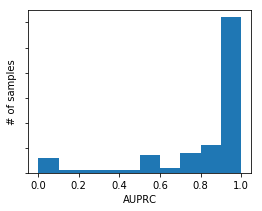

In [188]:
fig,ax=plt.subplots(figsize=(4,3))
praucDf['auprc'].hist(ax=ax)
#ax.set_yticklabels([])
ax.grid(False)
ax.set_yticklabels([])
ax.set_ylabel('# of samples')
ax.set_xlabel('AUPRC')

In [189]:
praucS=pd.Series(roc_auc_l).dropna()
(praucS>0.8).mean()

TypeError: '>' not supported between instances of 'dict' and 'float'

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


TypeError: '<' not supported between instances of 'dict' and 'float'

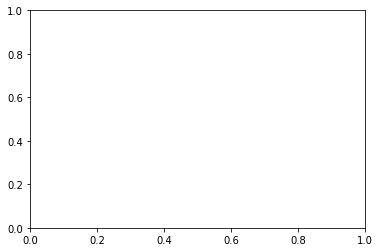

In [182]:
ax=pd.Series(roc_auc_l).hist(normed=True)
ax

In [99]:
wxsWithDataDf_base.head()

Empty DataFrame
Columns: [(rna-seq, ReadDepth), (rna-seq, AverageBaseQuality), (wxs, ReadDepth), (wxs, AverageBaseQuality)]
Index: []

In [20]:
threshold=2

selectedBase='T'
query_chromosome, qeury_corrdinate='2',208248388
m_chr=targetted_df.index.get_level_values('Chr')==query_chromosome
Pos_array=targetted_df.index.get_level_values('Pos')
window_size=0

m_pos=(Pos_array>=(qeury_corrdinate-window_size))&(Pos_array<=(qeury_corrdinate+window_size))
m_qual=targetted_df['AverageBaseQuality']>=30

targetted_df_sub=targetted_df[m_pos&m_qual]

index_metaDf=targetted_df_sub.index.to_frame()

index_metaDf['sample_barcode']=manifest_df_w_RNA_WXS.set_index('file_id').loc[index_metaDf['Run_digits']]['sample_barcode'].values

multI=index_metaDf.set_index(['sample_barcode','Run_digits','Chr','Pos','base']).index
targetted_df_sub.index=multI


rnaseq_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='RNA-Seq']['file_id'].unique()
m_uuid=targetted_df_sub.index.get_level_values('Run_digits').isin(rnaseq_uuids)
rnaseq_df=targetted_df_sub[m_uuid]

groupings_L=['sample_barcode','Chr','Pos','base']

rnaseq_df=rnaseq_df.groupby(groupings_L).first()

wxs_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='WXS']['file_id'].unique()
m_uuid=targetted_df_sub.index.get_level_values('Run_digits').isin(wxs_uuids)
wxs_df=targetted_df_sub[m_uuid]

wxs_df=wxs_df.groupby(groupings_L).first()

mergedDf=pd.concat([ rnaseq_df,wxs_df],axis=1,keys=['rna-seq','wxs'])

mergedDf['wxs']['ReadDepth']=mergedDf['wxs']['ReadDepth'].fillna(0)

#mergedDf

#for the whole 

from sklearn import metrics

#### get the homozygous

wxsWithDataDf=mergedDf#[mergedDf['wxs']['ReadDepth']>=threshold]

sampleRdS=wxsWithDataDf['wxs'].groupby('sample_barcode')['ReadDepth'].sum()

xwsSamplesWithCoverage=sampleRdS.index[sampleRdS>threshold]

m_base=wxsWithDataDf.index.get_level_values('base')==selectedBase

m_wxs_coverage=wxsWithDataDf.index.get_level_values('sample_barcode').isin(xwsSamplesWithCoverage)

m_valid_all=mergedDf.notnull().all(axis=1)

wxsWithDataDf_base=wxsWithDataDf[m_base&m_wxs_coverage]

wxsWithDataDf_base['rna-seq']=wxsWithDataDf_base['rna-seq'].fillna(0)

#wxsWithDataDf_base['rna-seq']['ReadDepth'].hist()

#wxsWithDataDf_base['wxs']['ReadDepth'].hist()

y_true=wxsWithDataDf_base['wxs']['ReadDepth']>=threshold



precision,recall,_=metrics.precision_recall_curve(y_true,
                               wxsWithDataDf_base['rna-seq']['ReadDepth'].fillna(0))
auprc=metrics.auc(recall,precision)

#group=wxsWithDataDf.groupby('base')

#for base, df in group:
#    break

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [296]:
index_metaDf=targetted_df_sub.index.to_frame()

index_metaDf['sample_barcode']=manifest_df_w_RNA_WXS.set_index('file_id').loc[index_metaDf['Run_digits']]['sample_barcode'].values

multI=index_metaDf.set_index(['sample_barcode','Run_digits','Chr','Pos','base']).index
targetted_df_sub.index=multI

wxs_df=targetted_df_sub[m_uuid]#.loc[wxs_uuid]

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
%time wxs_df=wxs_df.groupby(groupings_L).first()

CPU times: user 72 ms, sys: 32 ms, total: 104 ms
Wall time: 102 ms


In [30]:
rnaseq_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='RNA-Seq']['file_id'].unique()

m_uuid=targetted_df_sub.index.get_level_values('Run_digits').isin(rnaseq_uuids)

rnaseq_df=targetted_df_sub[m_uuid]#.loc[rnaseq_uuid]

In [31]:
%time rnaseq_df=rnaseq_df.groupby(groupings_L).first()

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 28.5 ms


In [32]:
mergedDf=pd.concat([ rnaseq_df,wxs_df],axis=1,keys=['rna-seq','wxs'])

In [33]:
mergedDf=mergedDf[~mergedDf.isnull().all(axis=1)]

## identify IDH1 mutations

In [34]:
#ref C
IDH1_corrdinate=208248388
mergedDf_subDf=mergedDf[mergedDf.index.get_level_values('Pos')==IDH1_corrdinate]

In [35]:
m_quality=(mergedDf_subDf['wxs']['AverageBaseQuality']>20)
ref_alt='T'
m_alt=(mergedDf_subDf.index.get_level_values('base'))==ref_alt

qualFilteredDf=mergedDf_subDf[m_quality]

In [36]:
unstackDf=qualFilteredDf.unstack()

In [37]:
unstackDf.head()

rna-seq                                      \
features                       ReadDepth                  AverageBaseQuality   
base                                   A      C   G     T                  A   
sample_barcode   Chr Pos                                                       
TCGA-CS-4938-01B 2   208248388       NaN   68.0 NaN  24.0                NaN   
TCGA-CS-4941-01A 2   208248388       NaN  235.0 NaN   NaN                NaN   
TCGA-CS-4942-01A 2   208248388       NaN  140.0 NaN  19.0                NaN   
TCGA-CS-4944-01A 2   208248388       NaN   43.0 NaN  17.0                NaN   
TCGA-CS-5390-01A 2   208248388       NaN   95.0 NaN  32.0                NaN   

                                                     wxs                   \
features                                       ReadDepth                    
base                               C   G     T         A      C   G     T   
sample_barcode   Chr Pos                                                    
TCGA-CS-4938-01B 2   208248388  37.0 NaN  38.0       NaN   87.0 NaN  29.0   
TCGA-CS-4941-01A 2   208248388  37.0 NaN   NaN       NaN  182.0 NaN   NaN   
TCGA-CS-4942-01A 2   208248388  38.0 NaN  38.0       NaN  192.0 NaN  46.0   
TCGA-CS-4944-01A 2   208248388  37.0 NaN  37.0       NaN  149.0 NaN  43.0   
TCGA-CS-5390-01A 2   208248388  37.0 NaN  38.0       NaN  141.0 NaN  51.0   

                                                                   
features                       AverageBaseQuality                  
base                                            A     C   G     T  
sample_barcode   Chr Pos                                           
TCGA-CS-4938-01B 2   208248388                NaN  29.0 NaN  29.0  
TCGA-CS-4941-01A 2   208248388                NaN  27.0 NaN   NaN  
TCGA-CS-4942-01A 2   208248388                NaN  25.0 NaN  28.0  
TCGA-CS-4944-01A 2   208248388                NaN  27.0 NaN  28.0  
TCGA-CS-5390-01A 2   208248388                NaN  26.0 NaN  27.0

In [38]:
from sklearn import metrics

In [39]:
import matplotlib.pyplot as plt

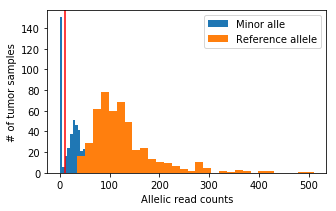

In [45]:

fig,ax=plt.subplots(figsize=(5,3))

unstackDf[('wxs','ReadDepth','T')].fillna(0).hist(bins=30,label='Minor alle',ax=ax)
unstackDf[('wxs','ReadDepth','C')].fillna(0).hist(bins=30,ax=ax,
                                                  label='Reference allele')
ax.axvline(x=10,c='red')
ax.set_ylabel('# of tumor samples')
ax.legend()
ax.set_xlabel('Allelic read counts')
ax.grid(False)


In [48]:
(unstackDf[('wxs','ReadDepth','T')]>0).sum()

351

In [41]:
asdasdas

NameError: name 'asdasdas' is not defined

In [ ]:
y_true=(>10)

In [ ]:
y_true.value_counts()

In [ ]:
print ('ROC AUC',metrics.roc_auc_score(y_true,
                      unstackDf[('rna-seq','ReadDepth','T')].fillna(0)))
precision, recall, thresholds=metrics.precision_recall_curve(y_true,
                      unstackDf[('rna-seq','ReadDepth','T')].fillna(0))
ax=pd.DataFrame({'precision':precision,'recall':recall}).plot(x='recall',y='precision')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
metrics.auc(recall,precision)
ax.set_title('IDH1 C>T mutation using RNAseq')

In [ ]:
import seaborn as sns

In [ ]:
qualFilteredDf[('wxs','ReadDepth')].index.get_level_values('base').value_counts()

In [ ]:
qualFilteredDf[('rna-seq','ReadDepth')].index.get_level_values('base').value_counts()

In [ ]:
qualFilteredDf[('rna-seq','ReadDepth')].index.get_level_values('base').value_counts()

In [ ]:
mergedDf_subDf

In [ ]:

qualFilteredDf['ReadDepth'],qualFilteredDf['wxs']>3

In [ ]:
##c 


In [ ]:
#qualFilteredDf[]

In [ ]:
unstackDf=qualFilteredDf['wxs'].unstack()['ReadDepth']

In [ ]:
#qualFilteredDf['wxs'].unstack()['ReadDepth']

In [ ]:
sns.jointplot(data=qualFilteredDf[qualFilteredDf.index.get_level_values('base')=='T'],x=('rna-seq','ReadDepth'),y=('wxs','ReadDepth'))


In [ ]:
#categorical_crossentropy

In [ ]:
### generate the correlation between the data 